# Implicit Bias v Demographics

In [1]:
# ! pip install pyreadstat

import bs4
from IPython.core.interactiveshell import InteractiveShell
import numpy as np
import pandas as pd
import requests

InteractiveShell.ast_node_interactivity = "all"

### _0. Download bias dataset to `iat.sav` and pickle to `iat.pkl` (already done)_

_This step is already done for you; no need to do it again._

Grab dataset `iat.sav` from 2018 from Harvard Project Implicit
 
    ! curl -L https://osf.io/z4bd2/download > iat.sav

Grab documentation for dataset columns `iat.xlsx`

    ! curl -L https://osf.io/szwuf/download > iat.xlsx
    pd.read_excel('iat.xlsx')

See also the Harvard Project Implicit Dataset homepage https://osf.io/y9hiq/  
and this [Blog post](https://app-prod-03.implicit.harvard.edu/implicit/user/jaxt/blogposts/piblogpost005.html)

Then we convert SPSS `iat.sav` to pickle `iat.pkl`  
It takes ~1h to read in the sav file

    df = pd.read_spss('iat.sav')
    df.to_pickle('iat.pkl')

### 1. Unpickle and clean bias dataset to `Iat`

In [2]:
Iat = pd.read_pickle('iat.pkl')[['raceomb_002', 'ethnicityomb', 'D_biep.White_Good_all', 'STATE']]
Iat.columns = ['Race','Ethnicity','Iat','State']

# Iat.head()
# Iat.describe(include='all').T

Iat = Iat[(Iat.Race=='White') & (Iat.Ethnicity=='Not Hispanic or Latino')]
Iat = Iat[['State','Iat']]

# Iat.head()
# np.array(Iat.State.unique())

Iat = pd.pivot_table(Iat,index='State',aggfunc=np.mean)
Iat = Iat.reset_index()

Iat.Iat = Iat.Iat*100 # Convert IAT to percentage

Iat.head()

,State,Iat
0,,34.924303
1,Alabama,37.231560
2,Alaska,33.057570
3,Arizona,34.999355
4,Arkansas,34.670178


### 2. Scrape and clean demograpic data to `df.Percent_Black`

In [3]:
link = 'https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations'
response = requests.get(link)
soup1 = bs4.BeautifulSoup(response.text, 'html.parser')

link = 'https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_African-American_population'
response = requests.get(link)
soup2 = bs4.BeautifulSoup(response.text, 'html.parser')

table = soup1.find_all('table')[0] 
State = pd.read_html(str(table))[0]
State = State.iloc[11:11+51,[0,5]]
State = State.reset_index(drop=True)
State.columns = ['State','USPS']

# State.head(10).T

table = soup2.find_all('table')[1]
Demographics = pd.read_html(str(table))[0]
Demographics = Demographics.iloc[:, [0,2]]
Demographics.columns = ['Percent_Black', 'State']

# Demographics.head(10).T

df = pd.merge(State, Demographics, how='left', on='State')
df.Percent_Black = df.Percent_Black.str.strip('%')
df.Percent_Black = df.Percent_Black.astype(float)

df.head(10).T

,0,1,2,3,4,5,6,7,8,9
State,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida
USPS,AL,AK,AZ,AR,CA,CO,CT,DE,DC,FL
Percent_Black,26.38,4.27,4.16,15.76,6.67,4.28,10.34,20.95,50.08,15.91


### 3. Merge bias data `Iat` into demographic data `df`

In [4]:
df = pd.merge(df, Iat, how='left', on='State')
df.head()

,State,USPS,Percent_Black,Iat
0,Alabama,AL,26.38,37.231560
1,Alaska,AK,4.27,33.057570
2,Arizona,AZ,4.16,34.999355
3,Arkansas,AR,15.76,34.670178
4,California,CA,6.67,32.418691


In [5]:
df = df.drop(df.index[df.USPS=='DC'])

### 4. Regression

In [6]:
from sklearn import linear_model
model = linear_model.LinearRegression()
model.fit(df[['Percent_Black']], df[['Iat']])

print(f'''

    Correlation between Percent_Black and IAT Racial Bias score of Whites is
    
        {df.Percent_Black.corr(df.Iat):.4f}
    
    Regression line is
    
        y = {model.coef_[0][0]:.2f}x + {model.intercept_[0]:.2f}

''')

pd.set_option('float_format', '{:.1f}'.format)

df['Predict_Iat'] = model.predict(df[['Percent_Black']])
df['Difference'] = df.Iat - df.Predict_Iat
df = df.sort_values(['Difference'], ascending=False)
df

df = df.sort_values(['Iat'], ascending=False)
df

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)



    Correlation between Percent_Black and IAT Racial Bias score of Whites is
    
        0.5036
    
    Regression line is
    
        y = 0.13x + 34.22




,State,USPS,Percent_Black,Iat,Predict_Iat,Difference
34,North Dakota,ND,1.1,39.3,34.4,4.9
30,New Jersey,NJ,14.5,40.8,36.0,4.8
48,West Virginia,WV,3.6,38.3,34.7,3.6
49,Wisconsin,WI,6.1,38.0,35.0,3.0
9,Florida,FL,15.9,38.7,36.2,2.4
27,Nebraska,NE,4.5,37.1,34.8,2.3
14,Indiana,IN,9.1,37.4,35.4,2.0
24,Mississippi,MS,37.3,40.8,38.9,1.9
15,Iowa,IA,2.7,36.4,34.6,1.9
6,Connecticut,CT,10.3,37.1,35.5,1.6


,State,USPS,Percent_Black,Iat,Predict_Iat,Difference
30,New Jersey,NJ,14.5,40.8,36.0,4.8
24,Mississippi,MS,37.3,40.8,38.9,1.9
34,North Dakota,ND,1.1,39.3,34.4,4.9
40,South Carolina,SC,28.5,38.7,37.8,0.9
9,Florida,FL,15.9,38.7,36.2,2.4
48,West Virginia,WV,3.6,38.3,34.7,3.6
49,Wisconsin,WI,6.1,38.0,35.0,3.0
7,Delaware,DE,20.9,37.4,36.8,0.6
14,Indiana,IN,9.1,37.4,35.4,2.0
0,Alabama,AL,26.4,37.2,37.5,-0.3


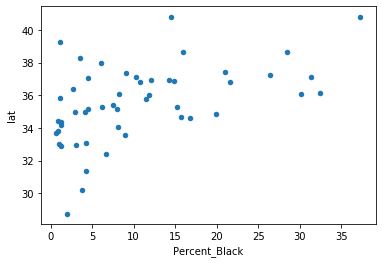

In [8]:
df.plot(x='Percent_Black', y='Iat', kind='scatter');

# Next Steps
1. ~~Download sav file using `! curl` with redirect flag -L~~
1. Scrape permalink for wiki demographics
1. Redo using 2010 IAT data, to match demographics data's year